# Et avec du fine tuning ?

En voyant que sur des réseaux de neurones "maison" les résultats étaient un peu décevant, nous avons décidé d'essayer la méthode évoquée en cours de transfert de connaissances. En faisant des recherches, nous avons décidé de nous limiter à deux modèles pour une question de temps : MobileNet et AlexNet.

Dans la suite, nous ne parlerons que d'AlexNet. Les résultats obtenus avec MobileNet étaient vraiment moins bons (dans les 30% d'accuracy), et cela malgré le fait que nous avons appliqué diverses modifications sur le modèle physique, en "freezant" certaines couches, changeant des paramètres comme le learning rate ou le type d'optimizer. 

# AlexNet fine tunning

In [2]:
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from matplotlib import pyplot as plt
import numpy as np
import os
import albumentations as A
from tqdm import tqdm

C:\Users\pH\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Généralités sur AlexNet

AlexNet est un réseau de neurone convolutionnel. En 2012, ses concepteurs (Alex Krizhevsky, Ilya Sutskever et Geoffrey Hinton) ont remportés grâce à ce réseau le ImageNet Large Scale Visual Recognition Challenge. Comme AlexNet a été conçu pour classifier des images complexes, il nous semblait adapté pour des images de mains et l'identification des doigts. Aussi, plusieurs articles présentent de bons résultats face à l'utilisation d'AlexNet pour la reconnaissance des mots du langage des signes. 

AlexNet est composé de 8 couches principales : 5 couches convolutionnelles et 3 fully connected couches. Il utilise la fonction d'activation RelU, introduite avec ce réseau de neurones. 

In [4]:
models.alexnet()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Data

Tout d'abord la taille des images. Nous avions vu en cours que les images passées dans AlexNet devaient être de taille 227x227x3. Nous avons donc utilisé les fonctions définies dans data.ipynb pour réaliser nos transformations, zoom sur les mains et redimensionnement des images.

Ici nous précisons que nous avons enlevé les images issues de dataset1 dans nos deux datasets maisons. Nous avions fait le choix initial de les ajouter malgré une qualité parfois un peu douteuse des signes pour ajouter de la matière aux datasets dans data.ipynb. Parce que notre fine tuning donne de meilleur résultat (une différence de 20% d'accuracy environ) sans ses images, nous les avons enlevées. Nous ne l'avons pas fait dans models.ipynb car il était trop tard pour tout recommencer.

### Implémentation

In [138]:
batch_size = 32
learning_rate = 1e-3
epochs = 40

On normalise les images pour qu'elles ressemblent à celles sur lequel le modèle a été entraîné, ImageNet. 

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisation ImageNet
])

In [140]:
# on prend le train et test dataset
# ImageFolder charge les images issues des dossiers tel que chaque type d'image dans un dossier different et donne les labels en fonction dossiers
dataset = datasets.ImageFolder(root='dataASLaug227', transform=transform)
test_dataset = datasets.ImageFolder(root='data_ASL_test227', transform=transform)

# on sépare le train dataset en train data et validation data
train_size = int(0.8 * len(dataset))
val_size =  len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# load les datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# informations utiles
print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

  # on récupère un batch
train_images, train_labels = next(iter(train_dataloader))
val_images, val_labels = next(iter(val_dataloader))

print("Training batch shape:", train_images.shape)
print("Validation batch shape:", val_images.shape)

class_names = dataset.classes
print("Classes:", class_names)
num_classes = len(class_names)

Total samples: 19942
Training samples: 15953
Testing samples: 94
Training batch shape: torch.Size([32, 3, 227, 227])
Validation batch shape: torch.Size([32, 3, 227, 227])
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'vide']


In [162]:
class_to_label = {class_name: idx for idx, class_name in enumerate(dataset.classes)}
label_to_class = {idx: class_name for class_name, idx in class_to_label.items()}

print("Class-to-Label Mapping:", class_to_label)
print("Label-to-Class Mapping:", label_to_class)

Class-to-Label Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'vide': 26}
Label-to-Class Mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'vide'}


On définit ensuite le modèle. Voici ici ce qui a le mieux marché. Nous avions fait des tests en freezant certaines couches de poids, en rajoutant des couches mais malheureusement rien n'a donné d'aussi bon résultat que de juste changer la sortie sur la dernière couche et d'utiliser les derniers poids mis à jours d'AlexNet. 

In [163]:
from torchvision.models import AlexNet_Weights
# on charge le modèle préentraîné avec les derniers poids
model = models.alexnet(weights=AlexNet_Weights.DEFAULT)
# On change la sortie de 1000 classes à 27 
model.classifier[6] = nn.Linear(4096, 27)

In [143]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [164]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: True


Nous n'avons pas changé la loss entre nos différents tests mais celle-ci nous paraissait robuste. Aussi, nous avons testé l'optimizer Adam mais nous avons eu des résultats un peu moins bon. Encore une fois, nous avons choisi de vous montrer le modèle et les paramètres qui ont le mieux marchés.

In [165]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [166]:
def train(model, loss=None, optimizer=None, train_dataloader=None, val_dataloader=None, nb_epochs=epochs):
    """Training loop"""

    min_val_loss = torch.inf
    train_losses = []
    val_losses = []

    # Iterrate over epochs
    for e in range(nb_epochs):

        # Training
        train_loss = 0.0

        for data, labels in train_dataloader:

            # Transfer data to GPU if available
            data = data.to(device)
            labels = labels.to(device, dtype=torch.long)

            # Reset gradients to 0
            optimizer.zero_grad()

            # Forward Pass (on reshaped data)
            targets = model(data)

            # Compute training loss
            current_loss = loss(targets, labels)
            train_loss += current_loss.item()

            # Compute gradients
            current_loss.backward()

            # Update weights
            optimizer.step()

        # Validation
        val_loss = 0.0

        # Put model in eval mode
        model.eval()

        for data, labels in val_dataloader:

            # Transfer data to GPU if available
            data = data.to(device)
            labels = labels.to(device, dtype=torch.long)

            # Forward Pass (on reshaped data)
            targets = model(data)

            # Compute validation loss
            current_loss = loss(targets, labels)
            val_loss += current_loss.item()

        # Prints
        print(f"Epoch {e+1}/{nb_epochs} \
                \t Training Loss: {train_loss/len(train_dataloader):.3f} \
                \t Validation Loss: {val_loss/len(val_dataloader):.3f}")

        train_losses.append(train_loss/len(train_dataloader))
        val_losses.append(val_loss/len(val_dataloader))

        # Save model if val loss decreases
        if val_loss < min_val_loss:

            min_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_alex1.pt')

    return train_losses, val_losses

In [167]:
train_losses, val_losses = train(model=model, loss=loss_fn, optimizer=optimizer,
                                 train_dataloader=train_dataloader, val_dataloader=val_dataloader,
                                 nb_epochs=10)

Epoch 1/10                 	 Training Loss: 2.495                 	 Validation Loss: 1.669
Epoch 2/10                 	 Training Loss: 1.209                 	 Validation Loss: 1.041
Epoch 3/10                 	 Training Loss: 0.741                 	 Validation Loss: 0.780
Epoch 4/10                 	 Training Loss: 0.491                 	 Validation Loss: 0.620
Epoch 5/10                 	 Training Loss: 0.340                 	 Validation Loss: 0.587
Epoch 6/10                 	 Training Loss: 0.236                 	 Validation Loss: 0.542
Epoch 7/10                 	 Training Loss: 0.162                 	 Validation Loss: 0.470
Epoch 8/10                 	 Training Loss: 0.110                 	 Validation Loss: 0.488
Epoch 9/10                 	 Training Loss: 0.075                 	 Validation Loss: 0.480
Epoch 10/10                 	 Training Loss: 0.049                 	 Validation Loss: 0.499


Nous sommes mitigées face à ces résultats. D'un côté, la validation loss ne remonte que sur la dernière epoch, mais d'un autre, elle ne descend pas très bas ... 

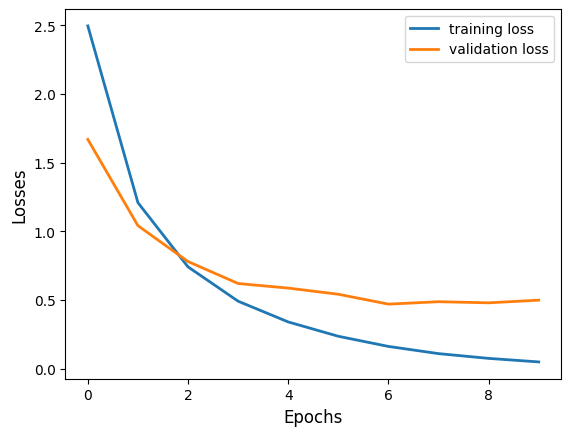

In [168]:
# Plot losses
plt.plot(range(len(train_losses)), train_losses,
         linewidth=2.0,
         label='training loss')

plt.plot(range(len(val_losses)), val_losses,
         linewidth=2.0,
         label='validation loss')

plt.xlabel("Epochs", size=12)
plt.ylabel("Losses", size=12)
plt.legend()

plt.savefig('losses.pdf')
plt.show()

### Analyse

In [169]:
def predict(model, dataloader):

    labels_l = []
    preds_l = []

    # Put model in eval mode
    model.eval()

    # Testing loop
    with torch.no_grad():

        for i, batch in enumerate(dataloader):

            data, labels = batch

            labels_l.extend(labels.tolist())
            preds = model(data.to(device))
            preds = torch.argmax(preds, dim=1)
            preds_l.extend(preds.tolist())

    return labels_l, preds_l

In [170]:
train_labels, train_preds = predict(model, train_dataloader)
test_labels, test_preds = predict(model, test_dataloader)

In [171]:
from sklearn.metrics import classification_report
print(classification_report(train_labels, train_preds, digits=4))
print(classification_report(test_labels, test_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9957    1.0000    0.9978       687
           1     0.9985    1.0000    0.9992       665
           2     0.9954    0.9977    0.9966       436
           3     0.9923    0.9981    0.9952       518
           4     0.9782    1.0000    0.9890       627
           5     1.0000    1.0000    1.0000       666
           6     0.9984    0.9984    0.9984       638
           7     1.0000    0.9984    0.9992       635
           8     0.9971    0.9943    0.9957       701
           9     0.9984    1.0000    0.9992       644
          10     1.0000    0.9984    0.9992       640
          11     0.9947    0.9973    0.9960       746
          12     1.0000    0.9734    0.9865       639
          13     1.0000    0.9795    0.9896       584
          14     1.0000    0.9959    0.9980       491
          15     0.9964    1.0000    0.9982       546
          16     0.9981    1.0000    0.9991       527
          17     1.0000    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


On obtient une accuracy de 63% ! C'est une belle amélioration par rapport à nos modèles maisons. On peut voir que certaines lettres ont été correctement classifiées pour chaque instance. Mais le dataset de test est petit, ce qui peut fausser nos résultats.

In [173]:
true_classes = []
val_images = []
for dirname, _ , filenames in os.walk('data_ASL_test227'):
    for filename in filenames:
      if filename != 'dataset/ASL_Dataset/Test':
        true_classes.append(os.path.basename(dirname))

        path=os.path.join(dirname, filename)
        img = Image.open(path)
        img_tensor = transform(img)
        val_images.append(img_tensor)
val_dataset = torch.stack(val_images)

In [174]:
model.eval()
with torch.no_grad():
    output = model(val_dataset.to(device))
output = output.cpu()
pred_labels = output.argmax(1).numpy()

In [175]:
def denormalize(image, mean, std):
    """
    Dé-normalise une image en utilisant les moyennes et écarts-types donnés.
    Tensor: Image dé-normalisée (C, H, W).
    """
    mean = np.array(mean)
    std = np.array(std)
    image = image.numpy().transpose((1, 2, 0))  # Convertir de (C, H, W) à (H, W, C)
    image = (image * std) + mean  # Dé-normalisation
    return np.clip(image, 0, 1)  # Limiter les valeurs à [0, 1]

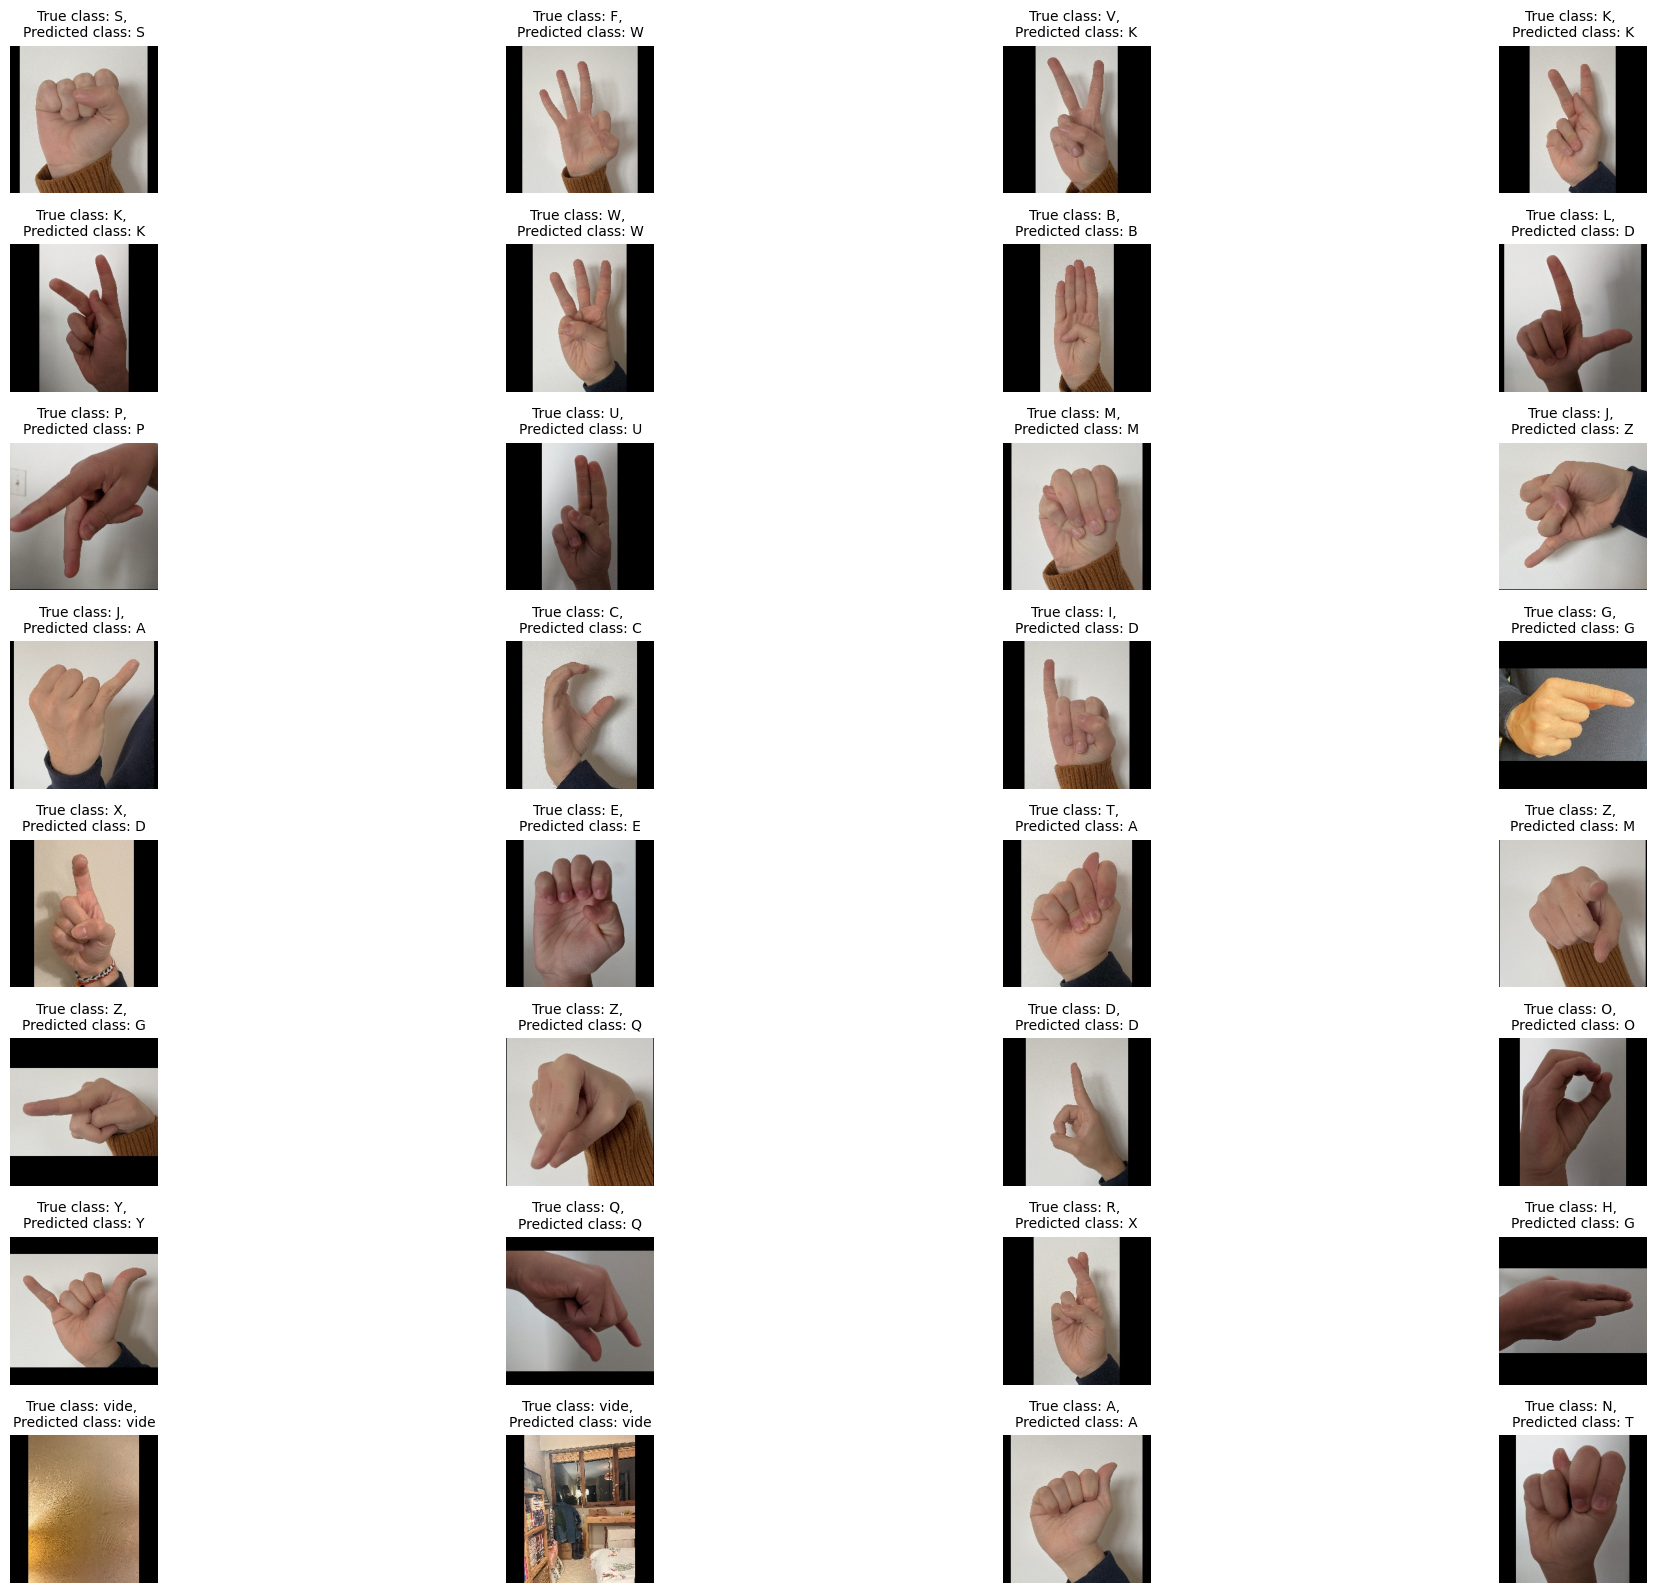

In [178]:
plt.figure(figsize=(20, 20))
for i in range(0, len(pred_labels), 3):
    plt.subplot(10, 4, (i+4)//3)

    # Dé-normaliser l'image avant affichage
    image = denormalize(val_images[i], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    plt.imshow(image)  # Afficher l'image
    plt.title(f"True class: {true_classes[i]}, \nPredicted class: {label_to_class[pred_labels[i]]}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

De manière générale, avec le code qui suit on peut conclure les choses suivantes : 
 - les lettres B, C, K, P, Q, R, S, U, W, Y, vide sont bien classifiées. On peut élargir à D globalement.
 - les lettres dynamiques J et Z ne donnent pas de bons résultats du tout.
 - le modèle a du mal à différencier les lettres A, E, M, T qui sont toutes signées avec la main en forme de poing
 - le modèle ne voit pas la différence entre U et K, le K se différencie plutôt en 3D, un doigt plus en avant par rapport à U
 - le modèle a du mal à différencier un G d'un H, on a un doigt de différence
 - le modèle est mauvais sur F, I, O

In [181]:
from collections import defaultdict
class_predictions = defaultdict(list)

for true, pred in zip(true_classes, pred_labels):
    class_predictions[true].append(label_to_class[pred])

# Trier les classes par ordre alphabétique
sorted_class_predictions = dict(sorted(class_predictions.items()))

for cls, preds in sorted_class_predictions.items():
    pred_classes = ", ".join(preds)
    print(f"{cls} : {pred_classes}")

# Sauvegarde des résultats dans un fichier texte
with open("class_predictions_sorted.txt", "w") as f:
    for cls, preds in sorted_class_predictions.items():
        pred_classes = ", ".join(preds)
        f.write(f"{cls} : {pred_classes}\n")

A : A, T, A
B : B, B, B
C : C, C, C
D : D, S, D, D, D
E : A, E, S
F : W, F, B
G : J, G, G
H : G, H, H
I : I, D, A
J : S, Q, Z, J, A, A, A
K : K, K, K, K
L : L, L, D
M : E, M, M
N : S, E, T
O : O, M, Q
P : P, P, P
Q : Q, Q, Q
R : X, R, R
S : S, S, S
T : A, A, T
U : U, U, U
V : K, K, K
W : W, W, W
X : X, D, X
Y : Y, Y, Y
Z : Z, M, Z, T, G, Z, Q, Q
vide : vide, vide, vide, vide
